# ICP SLAM lab #

This notebook is an overview about ICP and it's different implementations.

## Contents:
* [Overview](#Overview)
* [ICP based on SVD](#ICP-based-on-SVD)
* [Point to Plane Metric](#Point-to-Plane-Metric)
* [Dealing with outliers](#Dealing-with-outliers)
* [Real world Point CLouds](#Real-world-Point-CLouds)
* [Occupancy Mapping](#Occupancy-Mapping)

## Overview

Having two scans $P = \{p_i\}$ and $Q = \{q_i\}$ we want to find a transformation (rotation $R$ and translation $t$) to apply to $P$ to match $Q$ as good as possible. In the remainder of this notebook we will try to define what does "as good as possible" mean as well as ways to find such a transformation.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from math import sin, cos, atan2, pi
from IPython.display import display, Math, Latex, Markdown, HTML

### Visualization tools

In [2]:
def plot_data(data_1, data_2, label_1, label_2, markersize_1=8, markersize_2=8):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.axis('equal')
    if data_1 is not None:
        x_p, y_p = data_1
        ax.plot(x_p, y_p, color='red', markersize=markersize_1, marker='o', linestyle=":", label=label_1)
    if data_2 is not None:
        x_q, y_q = data_2
        ax.plot(x_q, y_q, color='#336699', markersize=markersize_2, marker='o', linestyle=":", label=label_2)
    ax.legend()
    return ax

def plot_values(values, label):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.plot(values, label=label)
    ax.legend()
    ax.grid(True)
    plt.show()
    
def animate_results(P_values, Q, corresp_values, xlim, ylim):
    """A function used to animate the iterative processes we use."""
    fig = plt.figure(figsize=(10, 6))
    anim_ax = fig.add_subplot(111)
    anim_ax.set(xlim=xlim, ylim=ylim)
    anim_ax.set_aspect('equal')
    plt.close()
    x_q, y_q = Q
    # draw initial correspondeces
    corresp_lines = []
    for i, j in correspondences:
        corresp_lines.append(anim_ax.plot([], [], 'grey')[0])
    # Prepare Q data.
    Q_line, = anim_ax.plot(x_q, y_q, 'o', color='#336699')
    # prepare empty line for moved data
    P_line, = anim_ax.plot([], [], 'o', color='red')

    def animate(i):
        P_inc = P_values[i]
        x_p, y_p = P_inc
        P_line.set_data(x_p, y_p)
        draw_inc_corresp(P_inc, Q, corresp_values[i])
        return (P_line,)
    
    def draw_inc_corresp(points_from, points_to, correspondences):
        for corr_idx, (i, j) in enumerate(correspondences):
            x = [points_from[0, i], points_to[0, j]]
            y = [points_from[1, i], points_to[1, j]]
            corresp_lines[corr_idx].set_data(x, y)
    
    anim = animation.FuncAnimation(fig, animate,
                                   frames=len(P_values), 
                                   interval=500, 
                                   blit=True)
    return HTML(anim.to_jshtml())

### Generate data

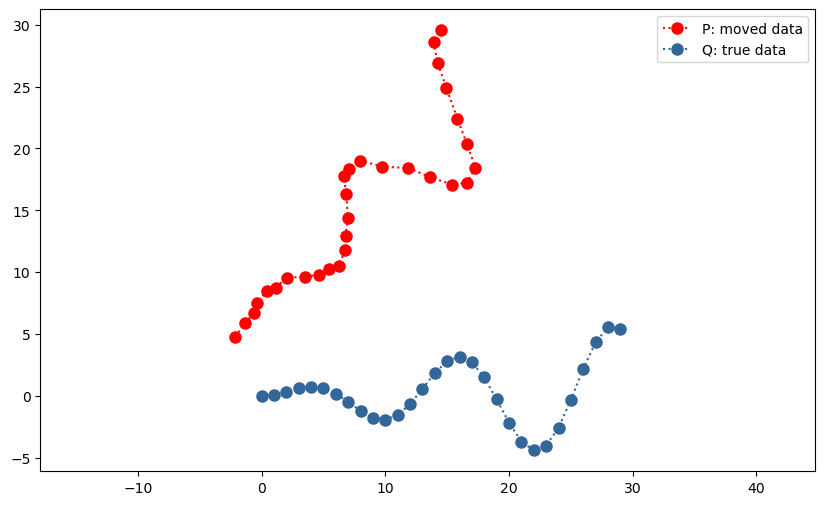

In [3]:
# initialize pertrubation rotation
theta = pi / 4
R_true = np.array([[cos(theta), -sin(theta)], 
                   [sin(theta),  cos(theta)]])
t_true = np.array([[-2], [5]])

# Generate data as a list of 2d points
num_points = 30
true_data = np.zeros((2, num_points))
true_data[0, :] = range(0, num_points)
true_data[1, :] = 0.2 * true_data[0, :] * np.sin(0.5 * true_data[0, :])

# Move the data
moved_data = R_true.dot(true_data) + t_true

# Add noise
n = 0.5 * (np.random.random((2, num_points)) - 0.5)  # noise
moved_data = moved_data + n

# Assign to variables we use in formulas.
Q = true_data
P = moved_data

plot_data(moved_data, true_data, "P: moved data", "Q: true data")
plt.show()

### Correspondences computation
We compute correspondences from $P$ to $Q$, i.e. for every $p_i$ we search the closest $q_j$ to it.

In [4]:
def get_correspondences(P, Q):
    """For each point in P find closest one in Q."""
    p_size = P.shape[1]
    q_size = Q.shape[1]
    ids = []
    dists = []
    for i in range(p_size):
        p_point = P[:, i]
        min_dist = sys.maxsize
        chosen_idx = -1
        for j in range(q_size):
            q_point = Q[:, j]
            dist = np.linalg.norm(q_point - p_point)
            if dist < min_dist:
                min_dist = dist
                chosen_idx = j
        ids.append(chosen_idx)
        dists.append(min_dist)
        
    return dists, ids

def draw_correspondeces(P, Q, correspondences, ax):
    label_added = False
    for i, j in correspondences:
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        if not label_added:
            ax.plot(x, y, color='grey', label='correpondences')
            label_added = True
        else:
            ax.plot(x, y, color='grey')
    ax.legend()

## ICP based on SVD

Tldr version. If the scans would match exactly, their cross-covariance would be identity. Therefore, we can iteratively optimize their cross-covariance to be as close as possible to an identity matrix by applying transformations to $P$. Let's dive into details. 

### Single iteration
In a single iteration we assume that the correspondences are known. We can compute the cross-covariance between the corresponding points. Let $C = \{\{i,j\}:p_i \leftrightarrow q_j\}$ be a set of all correspondences, also $|C| = N$. Then, the cross-covariance $H$ is computed as:

\begin{eqnarray}
H &=& E [(p_i - \mu_P)(q_j - \mu_Q)^T] \\
&=& \frac{1}{N}\sum_{\{i,j\} \in C}{(p_i - \mu_P)(q_j - \mu_Q)^T} \\
&\sim& \sum_{\{i,j\} \in C}{(p_i - \mu_P)(q_j - \mu_Q)^T}
\end{eqnarray}

Each point has two dimentions, that is $p_i, q_j \in {\rm I\!R}^2$, thus cross-covariance has the form of (we drop indices $i$ and $j$ for notation simplicity):

\begin{equation}
H =
  \begin{bmatrix}
    cov(p_x, q_x) & cov(p_x, q_y) \\
    cov(p_y, q_x) & cov(p_y, q_y)
  \end{bmatrix}
\end{equation}

-----
**Intuition:** Intuitevely, cross-covariance tells us how a coordinate of point $q$ changes with the change of $p$ coorinate, i.e. $cov(p_x, q_x)$ tells us how the $x$ coordinate of $q$ will change with the change in $x$ coordinate of $p$ given that the points are corresponding. Ideal cross-covariance matrix is an identity matrix, i.e., we want the $x$ coordinates to be ideally correlated between the scans $P$ and $Q$, while there should be no correlation between the $x$ coorinate of points from $P$ to the $y$ coordinate of points in $Q$. 
In our case, however, the position of $P$ is derived from the position of $Q$ through some rotation $R$ and translation $t$. Therefore, whenever we would move the scan $Q$, scan $P$ would move in a related way, but pertrubed through the rotation and translation applied, making the cross-covariance matrix non-identity.

----

Knowing the cross-covariance we can compute its SVD decomposition:

\begin{equation}
\mathrm{SVD}(H) = USV^T
\end{equation}

The SVD decomposition gives us how to rotate our data to align it with its prominent direction with $VU^T$ and how to scale it with its singular values $S$. Therefore:

\begin{eqnarray}
R &=& VU^T \\
t &=& \mu_Q - R \mu_P
\end{eqnarray}

#### Let's try this out: ####

### Make data centered

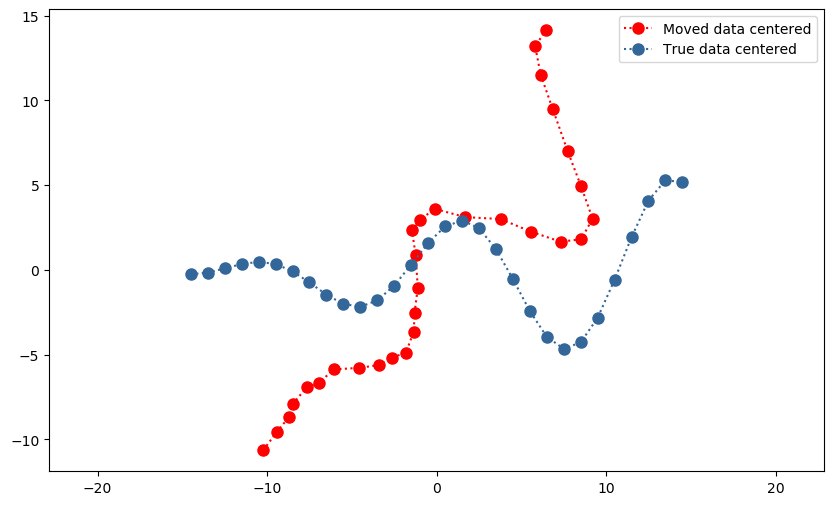

In [5]:
def center_data(data, exclude_indices=[]):
    reduced_data = np.delete(data, exclude_indices, axis=1)
    center = np.expand_dims(reduced_data.mean(axis=1), 1)

    return center, data - center

center_of_P, P_centered = center_data(P.copy())
center_of_Q, Q_centered = center_data(Q)
ax = plot_data(P_centered, Q_centered,
               label_1='Moved data centered', label_2='True data centered')
plt.show()

### Compute correspondences

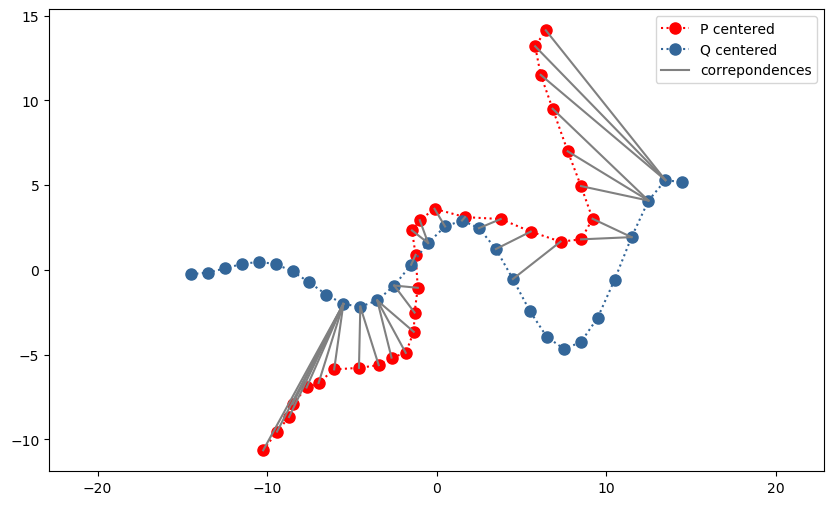

In [6]:
dists, ids = get_correspondences(P_centered, Q_centered)
ax = plot_data(P_centered, Q_centered,
               label_1='P centered', label_2='Q centered')
correspondences = [(i, j) for i, j in zip(range(P.shape[1]), ids)]
draw_correspondeces(P_centered, Q_centered, correspondences, ax)

For efficiency reason, we encourage you to use `scipy` implementation of nearest neighbors search at your homework assignment. The `get_correspondences` function implementation is provided for comparison. Let's double check if it works as expected:

In [7]:
from scipy.spatial import cKDTree

dists, ids = get_correspondences(P_centered, Q_centered)

tree = cKDTree(Q_centered.T)
dists2, ids2 = tree.query(P_centered.T)

print('Distances are same:', np.allclose(dists2, dists))
print('Indixes are same:', np.allclose(ids, ids2))

Distances are same: True
Indixes are same: True


### Compute covariance matrix

In [8]:
def compute_cross_covariance(P_centered, Q_centered, correspondences):
    # compute covariance matrix from point clouds
    # note that you need to use corresponding points correctly (!)
    
    correspondences = np.array(correspondences)
    
    p_idxs = correspondences[:, 0]
    q_idxs = correspondences[:, 1]

    s = (P_centered[:, p_idxs]) @ (Q_centered[:, q_idxs]).T
    
    return s

H = compute_cross_covariance(P_centered, Q_centered, correspondences)
print(f'Covariance matrix: \n {H}')

Covariance matrix: 
 [[1186.99469131  384.42211373]
 [1290.78134278  504.7764759 ]]


### Get transformation from SVD decomposition

In [9]:
def get_transform_from_cov(H, center_of_P, center_of_Q):
    # compute rotation and translation from covariance matrix and clouds centers
    # NB: Numpy returns H = U * diag(s) * V, not U * diag(s) * V'.
    U, S, Vh = np.linalg.svd(H, full_matrices=False)
    
    R = Vh.T @ U.T
    t = center_of_Q - R @ center_of_P

    return R, t

R_found, t_found = get_transform_from_cov(H, center_of_P, center_of_Q)
print("R_found =\n", R_found)
print("t_found =\n", t_found)

R_found =
 [[ 0.88146842  0.47224297]
 [-0.47224297  0.88146842]]
t_found =
 [[ 0.09499024]
 [-9.52108662]]


### Apply a single correction to $P$ and visualize the result
This is the result after just one iteration. Because our correspondences are not optimal, it is not a complete match.

[[ 0.09499024]
 [-9.52108662]]
[[ 0.88146842  0.47224297]
 [-0.47224297  0.88146842]]
Squared diff: (P_corrected - Q) =  14.420117441426687


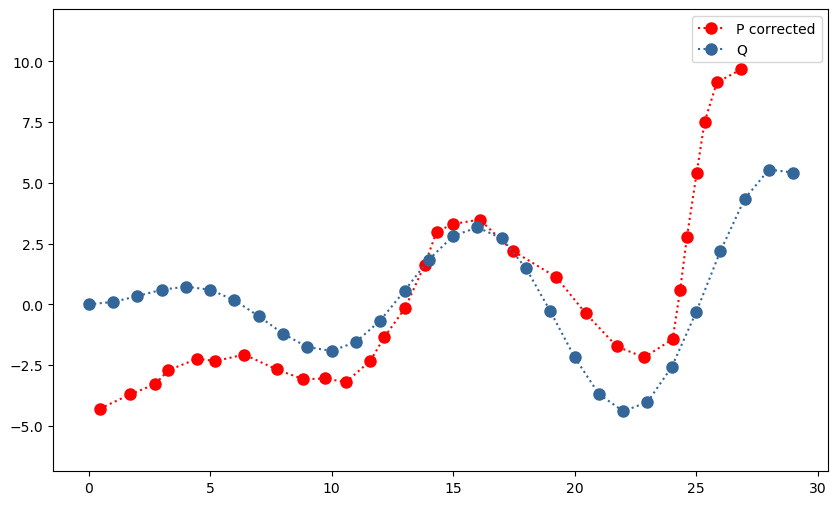

In [10]:
print(t_found)
print(R_found)
P_corrected = np.matmul(R_found, P) + t_found
ax = plot_data(P_corrected, Q, label_1='P corrected', label_2='Q')
print("Squared diff: (P_corrected - Q) = ", np.linalg.norm(P_corrected - Q))

## Let's make it iterative
If we would know the correct correspondences from the start, we would be able to get the optimal solution in a single iteration. This is rarely the case and we need to iterate. That consists of the following steps:

1. Make data centered by subtracting the mean, $P_{centered}$ and $Q_{centered}$.
2. For each point $P_i \in P_{centered}$ find its correspondence $Q_i \in Q_{centered}$.
3. Compute the cross-covariance matrix using $P_{centered}$, $Q_{centered}$, and **the found correspondences**.
4. Perform the SVD to find transformation that aligns the point clouds.
5. Apply the found transformation to $P$.

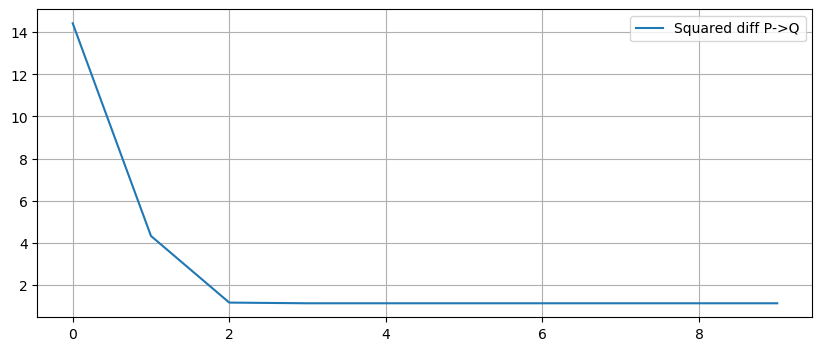

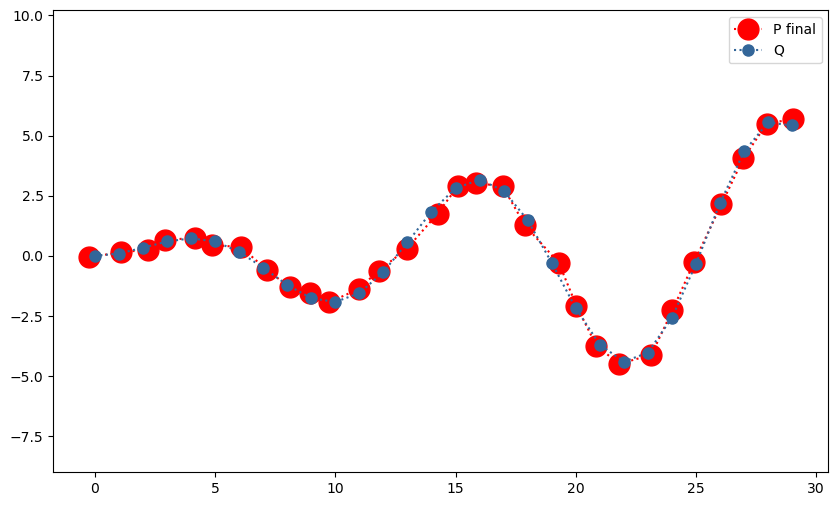

In [11]:
def icp(P, Q, iterations=10):
    """Perform ICP using SVD."""
    center_of_Q, Q_centered = center_data(Q)
    inl_errs = []
    P_values = [P.copy()]
    P_corrected = P.copy()
    
    corresp_values = []
    
    for i in range(iterations):
        # implement point-to-point ICP
        
        center_of_P, P_centered = center_data(P_corrected)
        
        dists, ids = get_correspondences(P_centered, Q_centered)
        correspondences = [(i, j) for i, j in zip(range(P_centered.shape[1]), ids)]
        
        H = compute_cross_covariance(P_centered, Q_centered, correspondences)
        
        R_found, t_found = get_transform_from_cov(H, center_of_P, center_of_Q)
        
        P_corrected = np.matmul(R_found, P_corrected) + t_found
        corresp_values.append(correspondences)
        inl_errs.append(np.linalg.norm(P_corrected - Q))
        P_values.append(P_corrected.copy())
    corresp_values.append(correspondences)
    return P_values, inl_errs, corresp_values

P_values, inl_errs, corresp_values = icp(P, Q)
plot_values(inl_errs, label="Squared diff P->Q")
ax = plot_data(P_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()

In [12]:
animate_results(P_values, Q, corresp_values, xlim=(-5, 35), ylim=(-5, 35))

## Point to Plane Metric

Point-to-point metric used before is not really the most optimal as can be seen above. It takes quite some iterations for the solution to converge. There is another metric which seems to work better. It is called "point-to-plane" metric. The idea here is that we still find the closest point, but the error is defined as a projection of the error onto the direction of the normal shot from the found point.

The normal in this 2D case is simple to compute. For a vector $v = [x, y]^\top$ the normal is a vector $n_v = [-y, x]^\top$ as can be shown geometrically.

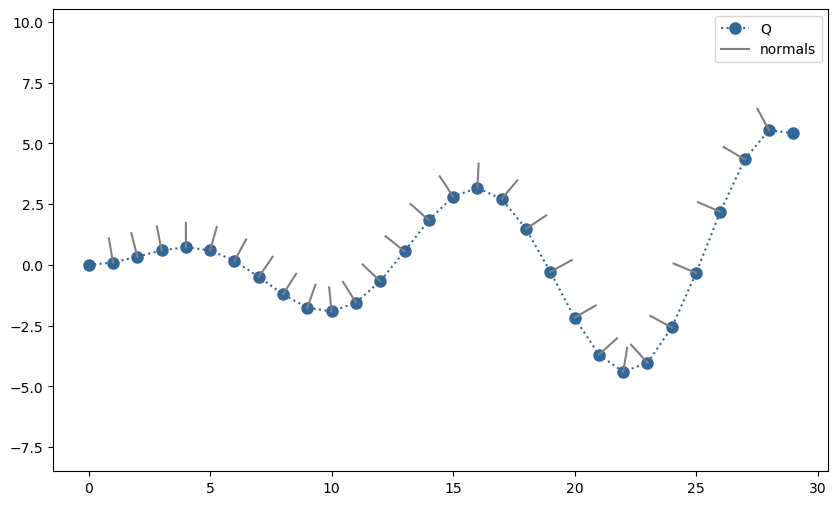

In [13]:
def compute_normals(points, step=1):
    normals = [np.array([[0, 0]])]
    normals_at_points = []
    for i in range(step, points.shape[1] - step):
        prev_point = points[:, i - step]
        next_point = points[:, i + step]
        curr_point = points[:, i]
        dx = next_point[0] - prev_point[0] 
        dy = next_point[1] - prev_point[1]
        normal = np.array([[0, 0],[-dy, dx]])
        normal = normal / np.linalg.norm(normal)
        normals.append(normal[[1], :])  
        normals_at_points.append(normal + curr_point)
    normals.append(np.array([[0, 0]]))
    return normals, normals_at_points

def plot_normals(normals, ax):
    label_added = False
    for normal in normals:
        if not label_added:
            ax.plot(normal[:,0], normal[:,1], color='grey', label='normals')
            label_added = True
        else:
            ax.plot(normal[:,0], normal[:,1], color='grey')
    ax.legend()
    return ax

Q_normals, Q_normals_to_draw = compute_normals(Q)
ax = plot_data(None, Q, None, 'Q')
ax = plot_normals(Q_normals_to_draw, ax)
plt.show()

### ICP with point-to-plane metric

The ICP algorithm with point-to-plane metric that we are implementing is quite similar to the one with point-to-point:

1. Make data centered by subtracting the mean, $P_{centered}$ and $Q_{centered}$.
2. For each point $p_i \in P_{centered}$ find its correspondence $q_j \in Q_{centered}$.
3. For each point in $p_i \in P_{centered}$ find location of its projection on surface of $Q_{centered}$ defined by corresponding neighbor normal. We will call this projection cloud $Q_{centered}^{plane}$. The projection point is denoted as $q_j^{plane} \in Q_{centered}^{plane}$.
4. Compute the cross-covariance matrix using $P_{centered}$, $Q_{centered}^{plane}$, and **the found correspondences**.
5. Perform the SVD to find transformation that aligns the point clouds.
6. Apply the found transformation to $P$.

![](./icp_point2plane.png)

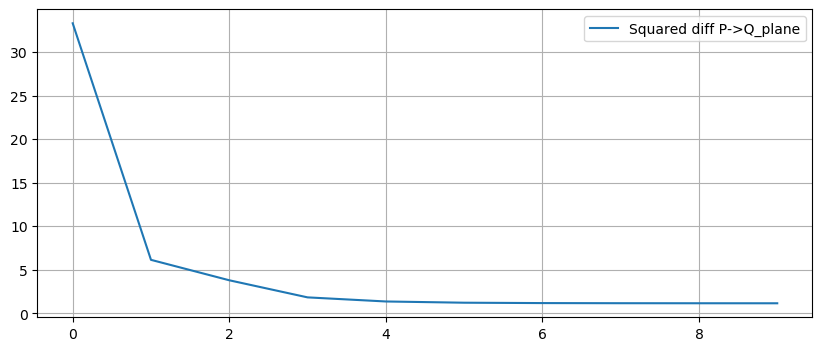

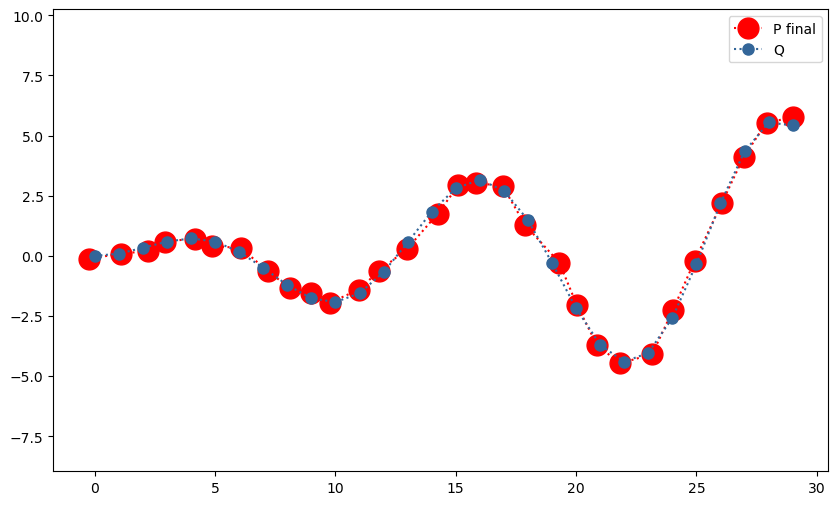

In [14]:
def icp_normals(P, Q, iterations=10):
    """Perform ICP using SVD."""
    center_of_Q, Q_centered = center_data(Q)
    inl_errs = []
    P_values = [P.copy()]
    P_corrected = P.copy()
    corresp_values = []
    Q_normals, _ = compute_normals(Q_centered)
    Q_normals = np.array(Q_normals).squeeze().T
    
    for i in range(iterations):
        # implement point-to-plane ICP
        
        center_of_P, P_centered = center_data(P_corrected)
        _, ids = get_correspondences(P_centered, Q_centered)
        correspondences = [(i, j) for i, j in zip(range(P_centered.shape[1]), ids)]

        dists = np.diag(Q_normals.T @ (P_centered - Q_centered))

        Q_plane = P_centered - dists * Q_normals
        
        H = compute_cross_covariance(P_centered, Q_plane, correspondences)
        
        R_found, t_found = get_transform_from_cov(H, center_of_P, center_of_Q)
        P_corrected = np.matmul(R_found, P_corrected) + t_found
        
        corresp_values.append(correspondences)
        inl_errs.append(np.linalg.norm(P_corrected - Q))
        P_values.append(P_corrected.copy())
        
    corresp_values.append(correspondences)
    return P_values, inl_errs, corresp_values

P_values, inl_errs, corresp_values = icp_normals(P, Q)
plot_values(inl_errs, label="Squared diff P->Q_plane")

ax = plot_data(P_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()

In [15]:
animate_results(P_values, Q, corresp_values, xlim=(-5, 35), ylim=(-10, 30))

# Dealing with outliers
If we corrupt our data, it gets harder for all of these algorithms to reason about it. 

Let's say, there is a couple pretty bad outliers in the $P$ data:

In [16]:
# Introduce outliers
P_outliers = P.copy()
P_outliers[:, 10] = np.array([-10, 30])
P_outliers[:, 20] = np.array([0, 40])

In [17]:
center_of_P_outliers = np.array([P_outliers.mean(axis=1)]).T
center_of_Q = np.array([Q.mean(axis=1)]).T
P_centered_outliers = P_outliers - center_of_P_outliers
Q_centered = Q - center_of_Q

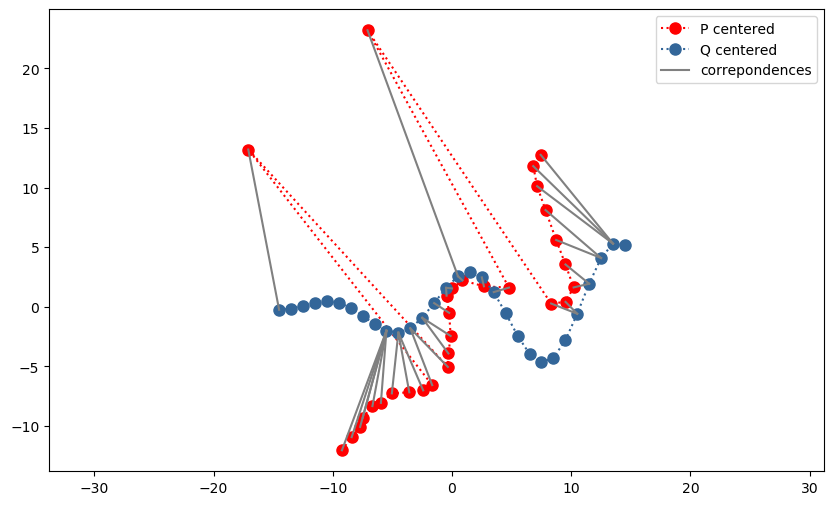

In [18]:
dists, ids = get_correspondences(P_centered_outliers, Q_centered)
correspondences = [(i, j) for i, j in zip(range(P_centered_outliers.shape[1]), ids)]
ax = plot_data(P_centered_outliers, Q_centered,
               label_1='P centered', label_2='Q centered')
draw_correspondeces(P_centered_outliers, Q_centered, correspondences, ax)
plt.show()

## We cannot just run our methods without modification
If we try to run any of the methods above without modification, they will fail as the outliers will "drag" the solution away from the one that looks visually the best. That is because the outliers generate quite a big error that becomes part of the optimization process, which tries to satisfy these new constraints.

#### Let's see what will happen if we just use the vanilla point-to-point ICP

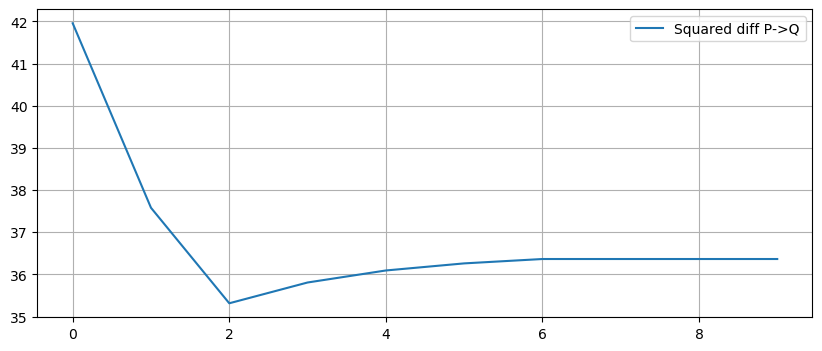

In [19]:
P_values, inl_errs, corresp_values = icp(P_outliers, Q)
plot_values(inl_errs, label="Squared diff P->Q")
animate_results(P_values, Q, corresp_values, xlim=(-5, 35), ylim=(-10, 30))

## Outliers rejection

SVD-based ICP has two steps: centering the data using its mean and optimizing the rotation. Let's looks at both starting with the rotational part.

#### Rotational part

It is relatively simple to remove the outliers during the rotation optimization. Each point contributes to the update of the cross-covariance matrix. We can exclude points that are too far apart from contributing to the update of the cross-covariance matrix, thus, removing them from the optimization. 

#### Translational part

This is the tricky part. As centering the data happens *before* we estimate correspondences and we define the outliers by the length of the correspondence, there is no way to know which of the data points are outliers. If we do nothing about it, we will *always* have a drift after the optimization. We could do the following:

- Find the first mean as if there were no outliers
- While performing rotation on that iteration, mark the points that are outliers (now we have correspondences and can do this)
- Apply the found rotation and translation
- Repeat the procedure excluding the marked outlier points from computing the mean.

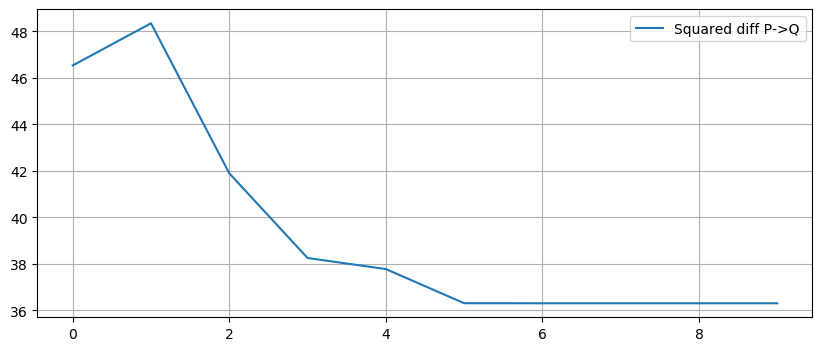

In [20]:
def icp(P, Q, iterations=10, dist_th=10.0):
    """Perform ICP using SVD."""
    center_of_Q, Q_centered = center_data(Q)
    inl_errs = []
    P_values = [P.copy()]
    P_copy = P.copy()
    corresp_values = []
    inl_mask = []
    
    # : use only inlier points to compute clouds means
    exclude_indices = []
    
    for i in range(iterations):
        

        center_of_P, P_centered = center_data(P_copy, exclude_indices=exclude_indices)

        dists, ids = get_correspondences(P_centered, Q_centered)
        correspondences = np.array([(i, j) for i, j in zip(range(P_centered.shape[1]), ids)])
        
        # : outlier rejection. Reject correspondencies which are too far away.
        
        inl_mask = np.array(dists) < 5
        exclude_indices = np.bitwise_not(inl_mask)
        
        
        correspondences = np.asarray(correspondences)[inl_mask]
        dists = np.asarray(dists)[inl_mask]
        
        H = compute_cross_covariance(P_centered, Q_centered, correspondences)
        R, t = get_transform_from_cov(H, center_of_P, center_of_Q)
        
        P_copy = R.dot(P_copy) + t
        P_values.append(P_copy)
        
        inl_errs.append(np.linalg.norm(P_copy - Q))
        corresp_values.append(correspondences)
        
    corresp_values.append(correspondences)
    
    return P_values, inl_errs, corresp_values

P_values, inl_errs, corresp_values = icp(P_outliers, Q)
# P_values, inl_errs, corresp_values = icp(P, Q)
plot_values(inl_errs, label="Squared diff P->Q")
animate_results(P_values, Q, corresp_values, xlim=(-5, 35), ylim=(-10, 30))

## Real world Point CLouds

Import Open3D library: http://www.open3d.org/

In [21]:
# !pip install open3d
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2023-03-26 15:46:27,509 - utils - NumExpr defaulting to 8 threads.
/home/mrs/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Download point cloud scans and their 6DoF poses in an environment.

The data set contains point cloud data captured in an indoor environment with precise localization and ground truth mapping information. Two ”stop-and-go” data sequences of a robot with mounted Ouster OS1-128 lidar are provided.
For more information about the data, please, refer to https://paperswithcode.com/dataset/fee-corridor..

In [22]:
path = './data'
id1, id2 = '1669300991_618086656', '1669301026_319255296'

if not os.path.exists(path):
    os.mkdir(path)
    url = 'http://ptak.felk.cvut.cz/vras/data/fee_corridor/sequences/seq2'
    os.system('wget %s/poses/poses.csv -P %s' % (url, path))
    os.system('wget %s/ouster_points/%s.npz -P %s' % (url, id1, path))
    os.system('wget %s/ouster_points/%s.npz -P %s' % (url, id2, path))
    os.system('wget https://github.com/AtsushiSakai/PythonRobotics/raw/master/Mapping/lidar_to_grid_map/lidar01.csv -P %s' % path)

### Helper functions to read the data

In [23]:
def read_poses(path):
    poses = np.genfromtxt(path, delimiter=', ', skip_header=True)
    ids = np.genfromtxt(path, delimiter=', ', dtype=str, skip_header=True)[:, 0].tolist()
    poses = poses[:, 2:]
    poses = poses.reshape((-1, 4, 4))
    poses = dict(zip(ids, poses))
    return poses

def read_cloud(npz_file):
    cloud = np.load(npz_file)['cloud']
    if cloud.ndim == 2:
        cloud = cloud.reshape((-1,))
    return cloud

In [24]:
# load cloud poses
poses = read_poses(os.path.join(path, 'poses.csv'))
pose1 = poses[id1]
pose2 = poses[id2]

# load point clouds
cloud1 = read_cloud(os.path.join(path, '%s.npz' % id1))
cloud2 = read_cloud(os.path.join(path, '%s.npz' % id2))

### Visualize point cloud with Open3D

In [25]:
from numpy.lib.recfunctions import structured_to_unstructured, unstructured_to_structured

def visualize_clouds(clouds, colors=None, show_normals=False):
    if colors:
        assert len(colors) == len(clouds)
    geoms = []
    for i, cloud in enumerate(clouds):
        pcd = o3d.geometry.PointCloud()
        points = structured_to_unstructured(cloud[['x', 'y', 'z']])
        pcd.points = o3d.utility.Vector3dVector(points)
        if colors:
            pcd.colors = o3d.utility.Vector3dVector(colors[i])
        if show_normals:
            normals = structured_to_unstructured(cloud[['normal_x', 'normal_y', 'normal_z']])
            pcd.normals = o3d.utility.Vector3dVector(normals)
        geoms.append(pcd)
    o3d.visualization.draw_geometries(geoms, point_show_normal=show_normals)
    
    
# matplotlib visualization version
def visualize_clouds_2d(P, Q, **kwargs):
    if P.dtype.names:
        P = structured_to_unstructured(P[['x', 'y', 'z']])
    if Q.dtype.names:
        Q = structured_to_unstructured(Q[['x', 'y', 'z']])

    plt.figure()

    plt.plot(P[:, 0], P[:, 1], 'o', label='source cloud', **kwargs)
    plt.plot(Q[:, 0], Q[:, 1], 'x', label='target cloud', **kwargs)

    plt.grid()
    plt.axis('equal')
    plt.legend()
    plt.show()

Use the following keyboard shortcuts to interact with the visualized cloud

```
-- Mouse view control --
  Left button + drag         : Rotate.
  Ctrl + left button + drag  : Translate.
  Wheel button + drag        : Translate.
  Shift + left button + drag : Roll.
  Wheel                      : Zoom in/out.

-- Keyboard view control --
  [/]          : Increase/decrease field of view.
  R            : Reset view point.
  Ctrl/Cmd + C : Copy current view status into the clipboard.
  Ctrl/Cmd + V : Paste view status from clipboard.

-- General control --
  Q, Esc       : Exit window.
  H            : Print help message.
  P, PrtScn    : Take a screen capture.
  D            : Take a depth capture.
  O            : Take a capture of current rendering settings.
```

Reference: http://www.open3d.org/docs/release/tutorial/visualization/visualization.html#Function-draw_geometries

In [26]:
visualize_clouds([cloud1], show_normals=True)

### Pair of scans Before alignment

/home/mrs/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


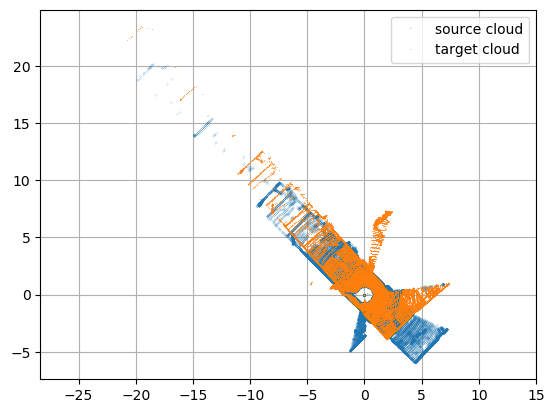

In [27]:
# green color for first point cloud and blue for the second scan
colors=[np.zeros((len(cloud1), 3)) + np.array([0, 1, 0]),
        np.zeros((len(cloud2), 3)) + np.array([0, 0, 1])]

visualize_clouds([cloud1, cloud2], colors)
visualize_clouds_2d(cloud1, cloud2, markersize=0.1)

### Aligned clouds with Transformation from data set

In [28]:
# ground truth transformation that aligns the point clouds (from data set)
Tr_gt = np.matmul(np.linalg.inv(pose2), pose1)
print(Tr_gt)

[[ 9.98493466e-01  5.47859414e-02  3.01519257e-03 -2.14119023e+00]
 [-5.47934989e-02  9.98495216e-01  2.26538171e-03  2.32402506e+00]
 [-2.88667163e-03 -2.42835646e-03  9.99992980e-01  1.67705490e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [29]:
def transform_cloud(Tr, cloud):
    cloud_tr = cloud.copy()
    points = structured_to_unstructured(cloud[['x', 'y', 'z']])
    points_tr = np.matmul(points, Tr[:3, :3].T) + Tr[:3, 3:].T
    cloud_tr[['x', 'y', 'z']] = unstructured_to_structured(points_tr, names=['x', 'y', 'z'])
    return cloud_tr

/home/mrs/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


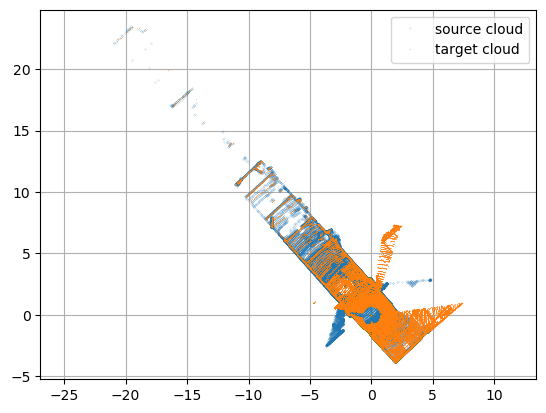

In [30]:
cloud1_tr = transform_cloud(Tr_gt, cloud1)

visualize_clouds([cloud1_tr, cloud2], colors=colors)
visualize_clouds_2d(cloud1_tr, cloud2, markersize=0.1)

### HW04

Implement `absolute_orientation` and `icp` functions in `aro_slam/icp.py` module. Feel free to use `icp_demo` function to test your implementation with the 3D point cloud scans from FEE Corridor:

```python
python -m aro_slam.icp
```

## Occupancy Mapping

In [31]:
def read_scan(f):
    """
    Reading LIDAR laser beams (angles and corresponding distance data)
    """
    with open(f) as data:
        measures = [line.split(",") for line in data]
    angles = []
    distances = []
    for measure in measures:
        angles.append(float(measure[0]))
        distances.append(float(measure[1]))
    angles = np.array(angles)
    distances = np.array(distances)
    
    return angles, distances

In [32]:
angles, distances = read_scan('./data/lidar01.csv')
angles[:5], distances[:5]

(array([0.00845042, 0.0469022 , 0.08508128, 0.19798226, 0.21189036]),
 array([0.5335, 0.5345, 0.537 , 0.2605, 0.2625]))

### Bresenham's Line Algorithm

Reference: https://en.wikipedia.org/wiki/Bresenham%27s_line_algorithm

In [33]:
def bresenham(start, end):
    """
    Implementation of Bresenham's line drawing algorithm
    See en.wikipedia.org/wiki/Bresenham's_line_algorithm
    Bresenham's Line Algorithm
    Produces a np.array from start and end (original from roguebasin.com)
    >>> points1 = bresenham((4, 4), (6, 10))
    >>> print(points1)
    np.array([[4,4], [4,5], [5,6], [5,7], [5,8], [6,9], [6,10]])
    """
    # setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1
    is_steep = abs(dy) > abs(dx)  # determine how steep the line is
    if is_steep:  # rotate line
        x1, y1 = y1, x1
        x2, y2 = y2, x2
    # swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True
    dx = x2 - x1  # recalculate differentials
    dy = y2 - y1  # recalculate differentials
    error = int(dx / 2.0)  # calculate error
    y_step = 1 if y1 < y2 else -1
    # iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        coord = [y, x] if is_steep else (x, y)
        points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += y_step
            error += dx
    if swapped:  # reverse the list if the coordinates were swapped
        points.reverse()
    points = np.array(points)
    
    return points

In [34]:
EXTEND_AREA = 1.0

def calc_grid_map_config(ox, oy, xy_resolution):
    """
    Calculates the size, and the maximum distances according to the the
    measurement center
    """
    min_x = round(min(ox) - EXTEND_AREA / 2.0)
    min_y = round(min(oy) - EXTEND_AREA / 2.0)
    max_x = round(max(ox) + EXTEND_AREA / 2.0)
    max_y = round(max(oy) + EXTEND_AREA / 2.0)
    xw = int(round((max_x - min_x) / xy_resolution))
    yw = int(round((max_y - min_y) / xy_resolution))
    print("The grid map is ", xw, "x", yw, ".")
    
    return min_x, min_y, max_x, max_y, xw, yw


def atan_zero_to_twopi(y, x):
    angle = math.atan2(y, x)
    if angle < 0.0:
        angle += math.pi * 2.0
    return angle

In [35]:
def generate_ray_casting_grid_map(ox, oy, xy_resolution):

    min_x, min_y, max_x, max_y, x_w, y_w = calc_grid_map_config(ox, oy, xy_resolution)
    
    # default 0.5 -- [[0.5 for i in range(y_w)] for i in range(x_w)]
    occupancy_map = np.ones((x_w, y_w)) / 2
    
    center_x = int(round(-min_x / xy_resolution))  # center x coordinate of the grid map
    center_y = int(round(-min_y / xy_resolution))  # center y coordinate of the grid map
    
    # occupancy grid computed with bresenham ray casting
    for (x, y) in zip(ox, oy):
        # x coordinate of the the occupied area
        ix = int(round((x - min_x) / xy_resolution))
        # y coordinate of the the occupied area
        iy = int(round((y - min_y) / xy_resolution))
        laser_beams = bresenham((center_x, center_y), (
            ix, iy))  # line form the lidar to the occupied point
        for laser_beam in laser_beams:
            occupancy_map[laser_beam[0]][
                laser_beam[1]] = 0.0  # free area 0.0
        occupancy_map[ix][iy] = 1.0  # occupied area 1.0
        occupancy_map[ix + 1][iy] = 1.0  # extend the occupied area
        occupancy_map[ix][iy + 1] = 1.0  # extend the occupied area
        occupancy_map[ix + 1][iy + 1] = 1.0  # extend the occupied area

    return occupancy_map, min_x, max_x, min_y, max_y, xy_resolution

In [36]:
xy_resolution = 0.02  # x-y grid resolution
ang, dist = read_scan("./data/lidar01.csv")

ox = np.sin(ang) * dist
oy = np.cos(ang) * dist

occupancy_map, min_x, max_x, min_y, max_y, xy_resolution = \
    generate_ray_casting_grid_map(ox, oy, xy_resolution)

The grid map is  150 x 100 .


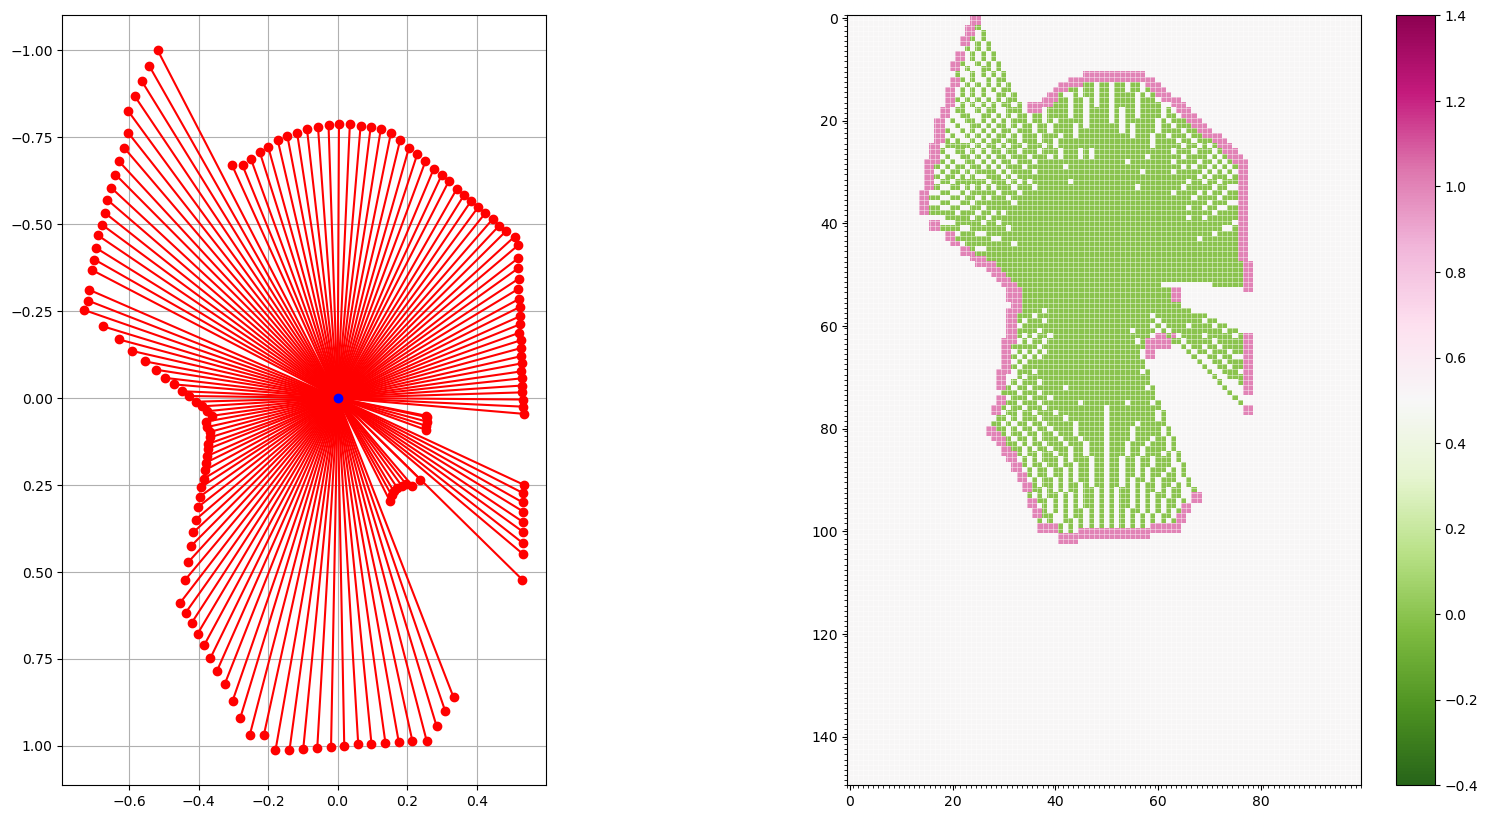

In [37]:
xy_res = np.array(occupancy_map).shape

plt.figure(1, figsize=(20, 10))
plt.subplot(122)
plt.imshow(occupancy_map, cmap="PiYG_r")
# cmap = "binary" "PiYG_r" "PiYG_r" "bone" "bone_r" "RdYlGn_r"
plt.clim(-0.4, 1.4)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="minor", color="w", linewidth=0.6, alpha=0.5)
plt.colorbar()

plt.subplot(121)
plt.plot([oy, np.zeros(np.size(oy))], [ox, np.zeros(np.size(oy))], "ro-")
plt.axis("equal")
plt.plot(0.0, 0.0, "ob")
plt.gca().set_aspect("equal", "box")
bottom, top = plt.ylim()  # return the current y-lim
plt.ylim((top, bottom))  # rescale y axis, to match the grid orientation
plt.grid(True)

plt.show()